In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import mlflow

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metric_preset import TargetDriftPreset

from sklearn import pipeline
import joblib
import shap

## Feature enginering

In [2]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
num_rows = 10000

In [4]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [5]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [6]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [7]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [8]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [9]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
df = application_train_test(num_rows)
bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR')
prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR')
pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR')
ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR')
cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR')

Train samples: 10000, test samples: 10000


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [12]:
df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          0      100002     1.0            0             0                0   
1          1      100003     0.0            1             0                1   
2          2      100004     0.0            0             1                0   
3          3      100006     0.0            1             0                0   
4          4      100007     0.0            0             0                0   
...      ...         ...     ...          ...           ...              ...   
19995   9995      172551     NaN            1             0                0   
19996   9996      172556     NaN            0             1                1   
19997   9997      172562     NaN            1             0                0   
19998   9998      172570     NaN            0             0                0   
19999   9999      172574     NaN            1             0                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0                 0          202500.0    406597.5      24700.5  ...   
1                 0          270000.0   1293502.5      35698.5  ...   
2                 0           67500.0    135000.0       6750.0  ...   
3                 0          135000.0    312682.5      29686.5  ...   
4                 0          121500.0    513000.0      21865.5  ...   
...             ...               ...         ...          ...  ...   
19995             0          135000.0    454500.0      29173.5  ...   
19996             1          180000.0    500490.0      52555.5  ...   
19997             0          202500.0    523152.0      37336.5  ...   
19998             1          382500.0    967500.0      31338.0  ...   
19999             1          112500.0    539100.0      22837.5  ...   

       CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
...                                   ...   
19995                                 NaN   
19996                                 NaN   
19997                                 NaN   
19998                                 0.0   
19999                                 NaN   

       CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
19995                                  NaN   
19996                                  NaN   
19997                                  NaN   
19998                                  0.0   
19999                                  NaN   

       CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                     NaN                                 NaN   
1                                     NaN                                 NaN   
2                                     NaN                                 NaN   
3                                     NaN                                 NaN   
4                                     NaN                                 NaN   
...                                   ...                                 ...   
19995                                 NaN                                 NaN   
19996                                 NaN                                 NaN   
19997                                 NaN                                 NaN   
19998                                 0.0                                 NaN   
19999                                 NaN                                 NaN   

       CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                                  NaN             

In [13]:
df.drop(columns='index', inplace=True)

In [14]:
df.isin([np.inf, -np.inf]).sum()

SK_ID_CURR                          0
TARGET                              0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
                                   ..
CC_NAME_CONTRACT_STATUS_nan_MAX     0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0
CC_NAME_CONTRACT_STATUS_nan_SUM     0
CC_NAME_CONTRACT_STATUS_nan_VAR     0
CC_COUNT                            0
Length: 767, dtype: int64

In [15]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df = df.dropna(axis=1, thresh = int(df.shape[0]*0.2))

In [16]:
colna = df.columns[df.isnull().any()].tolist()
colna.remove('TARGET')

for elmt1 in colna:
    df[elmt1] = df[elmt1].fillna(df[elmt1].median())

In [17]:
df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          100002     1.0            0             0                0   
1          100003     0.0            1             0                1   
2          100004     0.0            0             1                0   
3          100006     0.0            1             0                0   
4          100007     0.0            0             0                0   
...           ...     ...          ...           ...              ...   
19995      172551     NaN            1             0                0   
19996      172556     NaN            0             1                1   
19997      172562     NaN            1             0                0   
19998      172570     NaN            0             0                0   
19999      172574     NaN            1             0                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          202500.0    406597.5      24700.5   
1                 0          270000.0   1293502.5      35698.5   
2                 0           67500.0    135000.0       6750.0   
3                 0          135000.0    312682.5      29686.5   
4                 0          121500.0    513000.0      21865.5   
...             ...               ...         ...          ...   
19995             0          135000.0    454500.0      29173.5   
19996             1          180000.0    500490.0      52555.5   
19997             0          202500.0    523152.0      37336.5   
19998             1          382500.0    967500.0      31338.0   
19999             1          112500.0    539100.0      22837.5   

       AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
0             351000.0  ...                         0   
1            1129500.0  ...                         0   
2             135000.0  ...                         0   
3             297000.0  ...                         0   
4             513000.0  ...                         0   
...                ...  ...                       ...   
19995         454500.0  ...                         0   
19996         450000.0  ...                         0   
19997         463500.0  ...                         1   
19998         967500.0  ...                         0   
19999         450000.0  ...                         0   

       WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                    1                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   
...                                ...                        ...   
19995                                1                          0   
19996                                0                          0   
19997                                0                          0   
19998                                1                          0   
19999                                1                          0   

       EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
0                           1                        0            0.067329   
1                           1                        0            0.070862   
2                           0                        0            0.011814   
3                           0                        0            0.159905   
4                           0                        0            0.152418   
...                       ...                      ...                 ...   
19995                       1                        0            0.614244   
19996                       1                        0            0.141290   
19997                       1                        0            0.006618   
19998                       1              

In [18]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [19]:
test_df = test_df.reset_index(drop=True)

In [20]:
test_df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0         100001     NaN            1             0                0   
1         100005     NaN            0             0                0   
2         100013     NaN            0             1                0   
3         100028     NaN            1             0                0   
4         100038     NaN            0             1                1   
...          ...     ...          ...           ...              ...   
9995      172551     NaN            1             0                0   
9996      172556     NaN            0             1                1   
9997      172562     NaN            1             0                0   
9998      172570     NaN            0             0                0   
9999      172574     NaN            1             0                1   

      CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0          135000.0    568800.0      20560.5   
1                0           99000.0    222768.0      17370.0   
2                0          202500.0    663264.0      69777.0   
3                2          315000.0   1575000.0      49018.5   
4                1          180000.0    625500.0      32067.0   
...            ...               ...         ...          ...   
9995             0          135000.0    454500.0      29173.5   
9996             1          180000.0    500490.0      52555.5   
9997             0          202500.0    523152.0      37336.5   
9998             1          382500.0    967500.0      31338.0   
9999             1          112500.0    539100.0      22837.5   

      AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
0            450000.0  ...                         0   
1            180000.0  ...                         0   
2            630000.0  ...                         0   
3           1575000.0  ...                         1   
4            625500.0  ...                         0   
...               ...  ...                       ...   
9995         454500.0  ...                         0   
9996         450000.0  ...                         0   
9997         463500.0  ...                         1   
9998         967500.0  ...                         0   
9999         450000.0  ...                         0   

      WALLSMATERIAL_MODE_Stonebrick  WALLSMATERIAL_MODE_Wooden  \
0                                 1                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          0   
...                             ...                        ...   
9995                              1                          0   
9996                              0                          0   
9997                              0                          0   
9998                              1                          0   
9999                              1                          0   

      EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
0                          1                        0            0.121044   
1                          0                        0            0.247398   
2                          0                        0            0.222477   
3                          1                        0            0.133515   
4                          0                        0            0.168021   
...                      ...                      ...                 ...   
9995                       1                        0            0.614244   
9996                       1                        0            0.141290   
9997                       1                        0            0.006618   
9998                       1                        0            0.056491   
9999                       1                   

## modelisation

#### cross validate 
#### MLflow tracking

In [21]:
X = train_df.drop(columns=['TARGET'])
Y = train_df['TARGET']

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3)

In [23]:
X_train

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
8193      109554            1             0                0             0   
3897      104557            0             0                1             0   
9708      111298            0             1                1             2   
4605      105386            0             1                0             0   
284       100327            0             1                0             0   
...          ...          ...           ...              ...           ...   
3387      103955            1             0                0             0   
8263      109631            0             0                1             0   
2086      102447            1             1                0             2   
918       101060            0             0                1             0   
4437      105186            1             0                0             0   

      AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
8193          360000.0    927877.5      49437.0         801000.0   
3897          112500.0    225000.0      11074.5         225000.0   
9708          405000.0    436032.0      34578.0         360000.0   
4605          225000.0    149256.0      17842.5         135000.0   
284           180000.0    407727.0      32341.5         333000.0   
...                ...         ...          ...              ...   
3387          225000.0    731353.5      53347.5         661500.0   
8263           63000.0     56880.0       3829.5          45000.0   
2086           90000.0    609183.0      23733.0         508500.0   
918           270000.0   1546020.0      45202.5        1350000.0   
4437          382500.0    900000.0      31887.0         900000.0   

      REGION_POPULATION_RELATIVE  ...  WALLSMATERIAL_MODE_Panel  \
8193                    0.009630  ...                         0   
3897                    0.006305  ...                         0   
9708                    0.009549  ...                         0   
4605                    0.007274  ...                         1   
284                     0.020713  ...                         0   
...                          ...  ...                       ...   
3387                    0.032561  ...                         1   
8263                    0.008019  ...                         0   
2086                    0.035792  ...                         0   
918                     0.008625  ...                         1   
4437                    0.019101  ...                         0   

      WALLSMATERIAL_MODE_Stonebrick  WALLSMATERIAL_MODE_Wooden  \
8193                              0                          0   
3897                              0                          0   
9708                              1                          0   
4605                              0                          0   
284                               0                          0   
...                             ...                        ...   
3387                              0                          0   
8263                              0                          1   
2086                              0                          0   
918                               0                          0   
4437                              1                          0   

      EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
8193                       0                        0            0.123750   
3897                       0                        0            0.162987   
9708                       1                        0            0.059597   
4605                       1                        0            0.021671   
284                        0                        0            0.114879   
...                      ...                      ...                 ...   
3387                       1                        0            0.010849   
8263                       1          

In [24]:
y_test

947     0.0
9872    0.0
2415    0.0
6187    0.0
3326    1.0
       ... 
5205    0.0
3978    0.0
8888    0.0
4832    0.0
3036    0.0
Name: TARGET, Length: 3000, dtype: float64

In [25]:
oversample = SMOTE()
X_trainsmote, y_trainsmote = oversample.fit_resample(X_train, y_train)

In [26]:
modeles = [LGBMClassifier, DummyClassifier, LogisticRegression,  GradientBoostingClassifier]

In [27]:
dic = dict()
for e in modeles:
    resultats = cross_validate(e(), X_trainsmote, y_trainsmote, cv=5, scoring=['accuracy', 'roc_auc'])
    dic[e.__name__] = [resultats[i].mean() for i in resultats.keys()]
df_scores = pd.DataFrame.from_dict(dic, orient='index', columns=[i for i in resultats.keys()])

[LightGBM] [Info] Number of positive: 5176, number of negative: 5176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18535
[LightGBM] [Info] Number of data points in the train set: 10352, number of used features: 194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5176, number of negative: 5176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18462
[LightGBM] [Info] Number of data points in the train set: 10352, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5176, number of negative: 5176
[LightGBM] [Info] Auto-choosing col-wise multi-thread

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [28]:
dic

{'LGBMClassifier': [1.5200309753417969,
  0.07041807174682617,
  0.9544822256568779,
  0.981300330379901],
 'DummyClassifier': [0.02824435234069824, 0.005678987503051758, 0.5, 0.5],
 'LogisticRegression': [0.569242000579834,
  0.04084978103637695,
  0.6260432766615146,
  0.6684039282480787],
 'GradientBoostingClassifier': [51.94937310218811,
  0.06435976028442383,
  0.9498454404945903,
  0.9759577553277641]}

In [29]:
#import sklearn
#sklearn.metrics.get_scorer_names()

In [30]:
df_scores

fit_time  score_time  test_accuracy  test_roc_auc
LGBMClassifier               1.520031    0.070418       0.954482      0.981300
DummyClassifier              0.028244    0.005679       0.500000      0.500000
LogisticRegression           0.569242    0.040850       0.626043      0.668404
GradientBoostingClassifier  51.949373    0.064360       0.949845      0.975958

In [31]:
dic_metric = df_scores.to_dict("index")

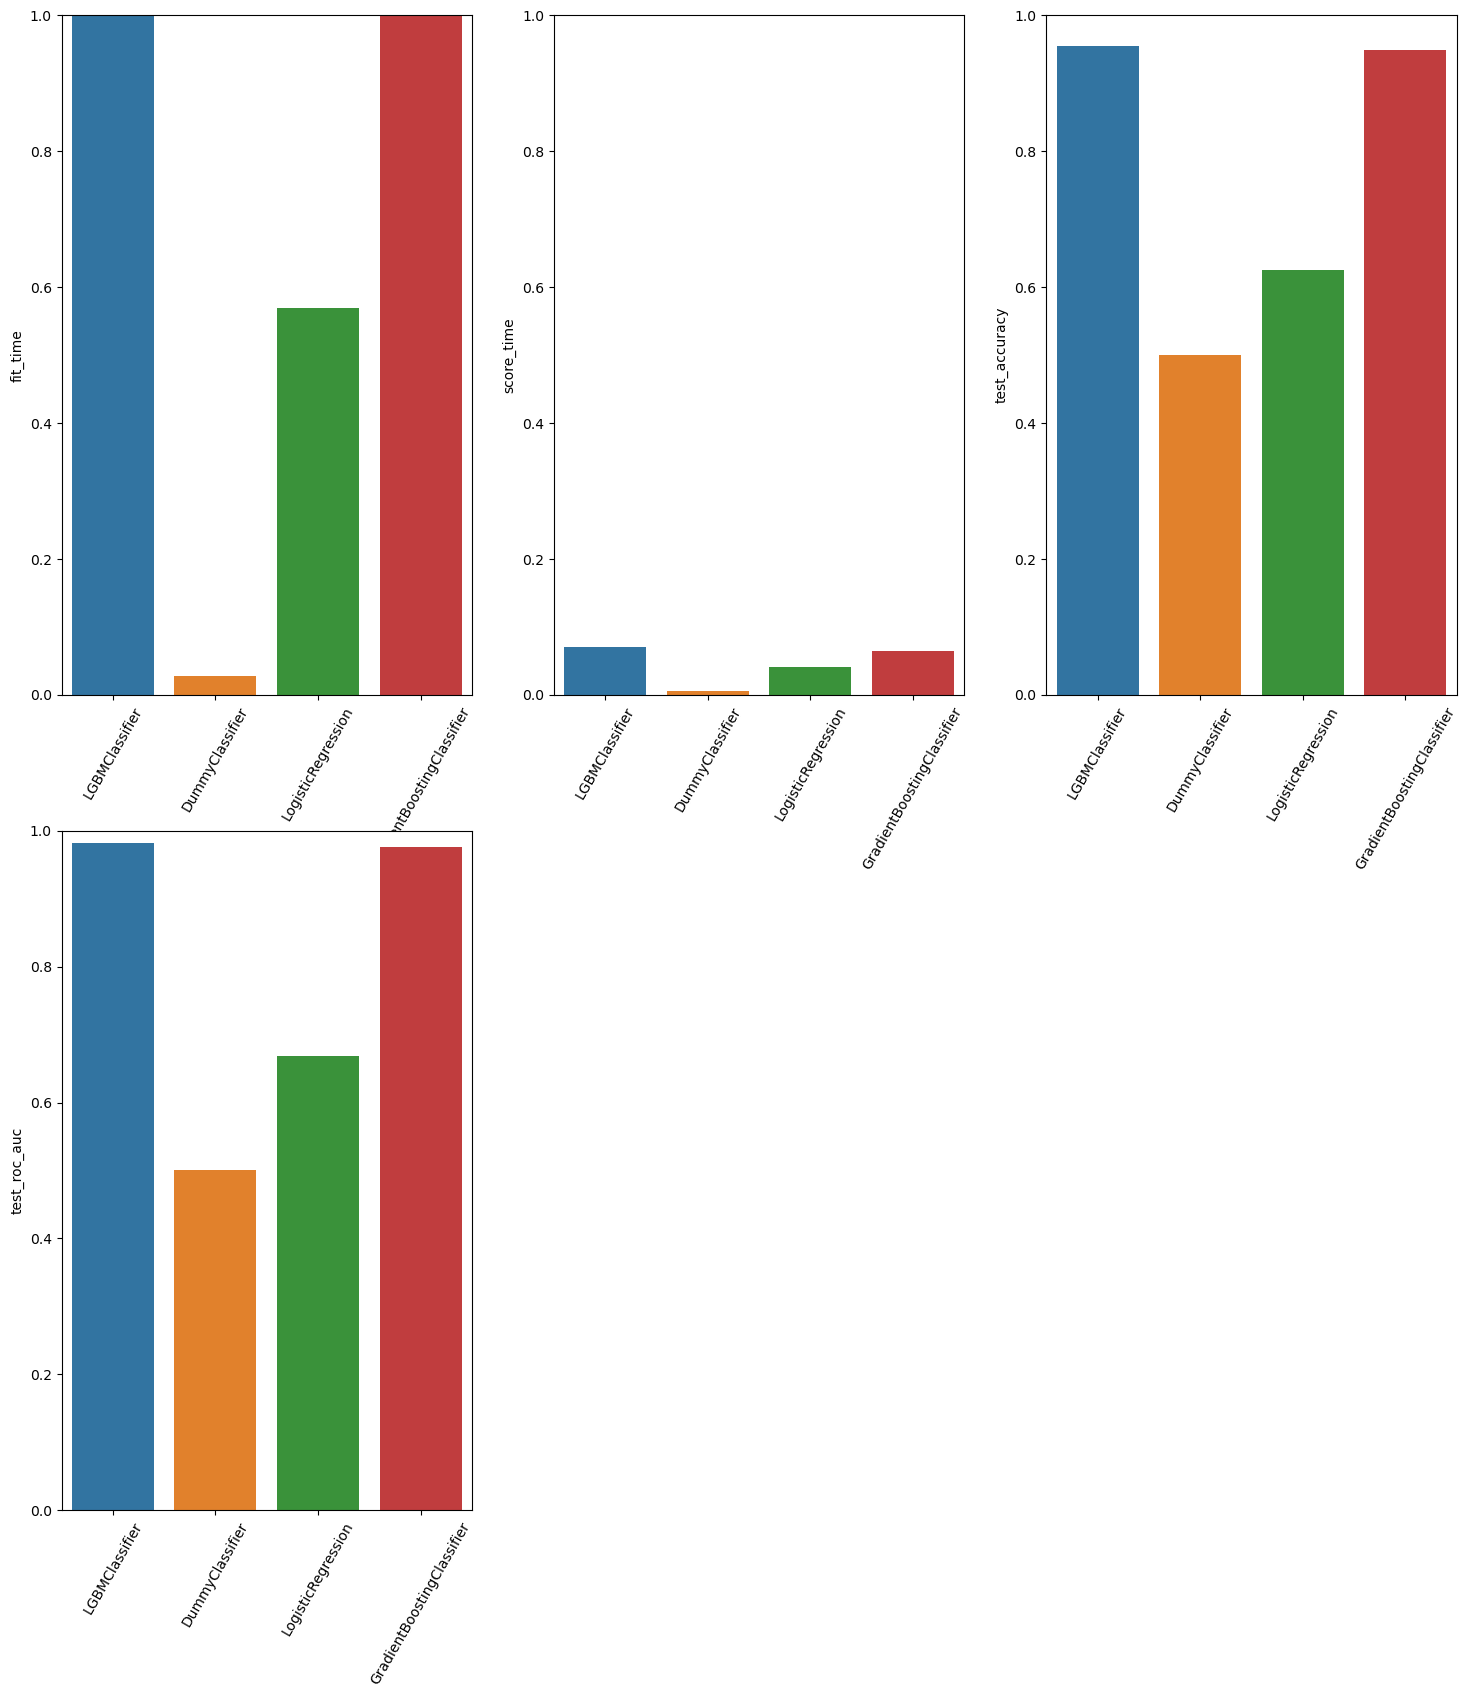

In [32]:
# Graph of the result of the cross validation
plt.figure(figsize=(18,30))
metric = list(resultats.keys())
for i in range(len(metric)):
    plt.subplot(3,3,i+1)
    sns.barplot(x=df_scores.index , y=df_scores[metric[i]])
    plt.xticks(rotation=60)
    plt.ylim((0,1))
plt.savefig('pred.png')
plt.show()

In [34]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("tracking")

mlflow.get_tracking_uri() 

2023/12/23 11:39:02 INFO mlflow.tracking.fluent: Experiment with name 'tracking' does not exist. Creating a new experiment.


'http://127.0.0.1:8080'

In [35]:
mlflow.get_tracking_uri() 

'http://127.0.0.1:8080'

In [36]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='DummyClassifier'):
    mlflow.set_tag("model_name", "DummyClassifier")
    
    DC = DummyClassifier()
    DC.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["DummyClassifier"])
    
    mlflow.sklearn.log_model(DC, "sk_models")

Setuptools is replacing distutils.


In [37]:
with mlflow.start_run(run_name='LogisticRegression'):
    mlflow.set_tag("model_name", "LogisticRegression")
    
    lr = LogisticRegression()
    lr.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["LogisticRegression"])
    
    mlflow.sklearn.log_model(lr, "sk_models")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [38]:
with mlflow.start_run(run_name='GradientBoostingClassifier'):
    mlflow.set_tag("model_name", "GradientBoostingClassifier")
    
    gb = GradientBoostingClassifier()
    gb.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["GradientBoostingClassifier"])
    
    mlflow.sklearn.log_model(gb, "sk_models")

In [39]:
with mlflow.start_run(run_name='LGBMClassifier'):
    mlflow.set_tag("model_name", "LGBMClassifier")
    
    lgb = LGBMClassifier()
    lgb.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["LGBMClassifier"])
    
    mlflow.sklearn.log_model(lgb, "sk_models")

[LightGBM] [Info] Number of positive: 6470, number of negative: 6470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18573
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


## Gridshearch avec comme metric auc_roc

In [103]:
params_lgb = {
    'num_leaves': [31, 200],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
    }

lgb = LGBMClassifier(random_state=42)

grid_searchlgb = GridSearchCV(estimator = lgb, param_grid = params_lgb, scoring='roc_auc', n_jobs = -1, verbose = 2)

grid_searchlgb.fit(X_trainsmote, y_trainsmote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6470, number of negative: 6470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18527
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

GridSearchCV(estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'min_data_in_leaf': [30, 50, 100],
                         'num_leaves': [31, 200], 'reg_alpha': [0.1, 0.5]},
             scoring='roc_auc', verbose=2)

In [102]:
print('The score :', grid_searchlgb.best_score_, 
      '\n the best estimator :', grid_searchlgb.best_estimator_, 
      'with the best parameter :', grid_searchlgb.best_params_)

The score : 0.9801960779629677 
 the best estimator : LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.5) with the best parameter : {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_leaves': 31, 'reg_alpha': 0.5}


In [95]:
lgb = LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.5)

lgb.fit(X_trainsmote, y_trainsmote)

y_pred = lgb.predict(X_test)

y_pred_proba = lgb.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6470, number of negative: 6470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18527
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain

<Axes: >

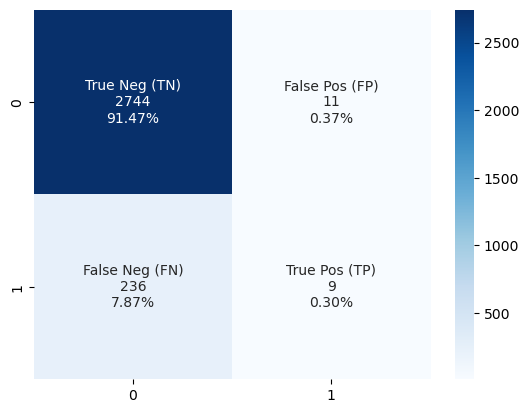

In [96]:
cf_matrix = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()   
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
tpr = float(np.divide(tp,(tp+fn)))
fpr= float(np.divide(fp,(fp+tn)))

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

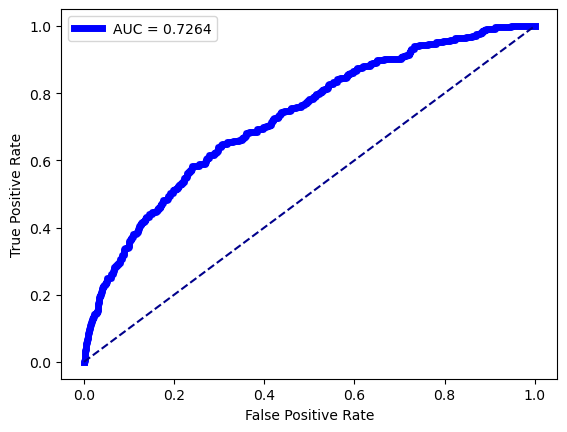

In [97]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='blue', linewidth=5, label='AUC = %0.4f' % roc_auc)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## Gridshearch avec comme metrique metier

In [113]:
def business_cost(y_test, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    
    #pfp = fp / np.sum(cf_matrix) *100
    fpr = fp / (fp + tn)
    
    #pfn = fn / np.sum(cf_matrix) *100
    
    fnr = fn / (fn + tp)
    
    return fpr + 15 * fnr

In [114]:
business_cost(y_test, y_pred)

14.452972332308605

In [115]:
grid_searchlgbmetier = GridSearchCV(estimator = lgb, param_grid = params_lgb, scoring=make_scorer(business_cost, greater_is_better=False), n_jobs = -1, verbose = 2)

grid_searchlgbmetier.fit(X_trainsmote, y_trainsmote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6470, number of negative: 6470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18555
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

GridSearchCV(estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'min_data_in_leaf': [30, 50, 100],
                         'num_leaves': [31, 200], 'reg_alpha': [0.1, 0.5]},
             scoring=make_scorer(business_cost, greater_is_better=False),
             verbose=2)

In [116]:
print('The score :', grid_searchlgbmetier.best_score_, 
      '\n the best estimator :', grid_searchlgbmetier.best_estimator_, 
      'with the best parameter :', grid_searchlgbmetier.best_params_)

The score : -1.2508500772797526 
 the best estimator : LGBMClassifier(max_depth=5, min_data_in_leaf=30, random_state=42, reg_alpha=0.1) with the best parameter : {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 30, 'num_leaves': 31, 'reg_alpha': 0.1}


In [117]:
lgbmetier = LGBMClassifier(max_depth=5, min_data_in_leaf=30, random_state=42,
               reg_alpha=0.1)
#(max_depth=5, min_data_in_leaf=30, random_state=42, reg_alpha=0.1)

lgbmetier.fit(X_trainsmote, y_trainsmote)

y_predm = lgbmetier.predict(X_test)

y_pred_probam = lgbmetier.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6470, number of negative: 6470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18555
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain

<Axes: >

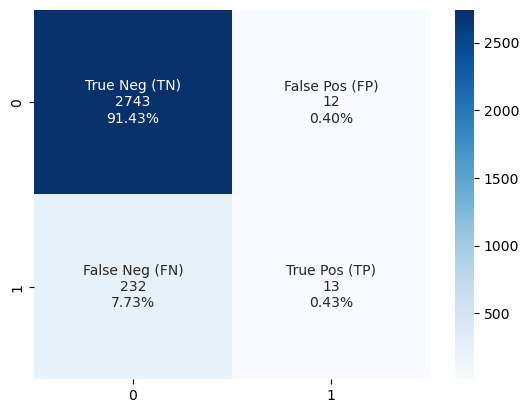

In [118]:
cf_matrix = confusion_matrix(y_test, y_predm)

tn, fp, fn, tp = confusion_matrix(y_test, y_predm, labels=[0, 1]).ravel()   
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
tpr = float(np.divide(tp,(tp+fn)))
fpr= float(np.divide(fp,(fp+tn)))

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

## Data drift

In [119]:
reference = train_df.drop(columns=['TARGET'])
current = test_df.drop(columns=['TARGET'])

column_mapping = ColumnMapping()

column_mapping.id = 'SK_ID_CURR'
column_mapping.features = list(current.columns) 

In [120]:
drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=reference, current_data=current, column_mapping=column_mapping)
drift_report

In [122]:
drift_report.save_html("data_drift.html") # Changer le nom de mon fichier 

### Pipeline prediction

In [123]:
pipeline1 = pipeline.Pipeline([('LGBM', LGBMClassifier(max_depth=5, min_data_in_leaf=30, random_state=42, reg_alpha=0.1))])

In [124]:
pipeline1.fit(X_trainsmote , y_trainsmote)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6470, number of negative: 6470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18555
[LightGBM] [Info] Number of data points in the train set: 12940, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain

Pipeline(steps=[('LGBM',
                 LGBMClassifier(max_depth=5, min_data_in_leaf=30,
                                random_state=42, reg_alpha=0.1))])

In [125]:
pipeline1.score(X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.9186666666666666

In [69]:
joblib.dump(pipeline1, 'best_model.joblib')

['best_model.joblib']

## Feature Importance 

##### Feature importance global

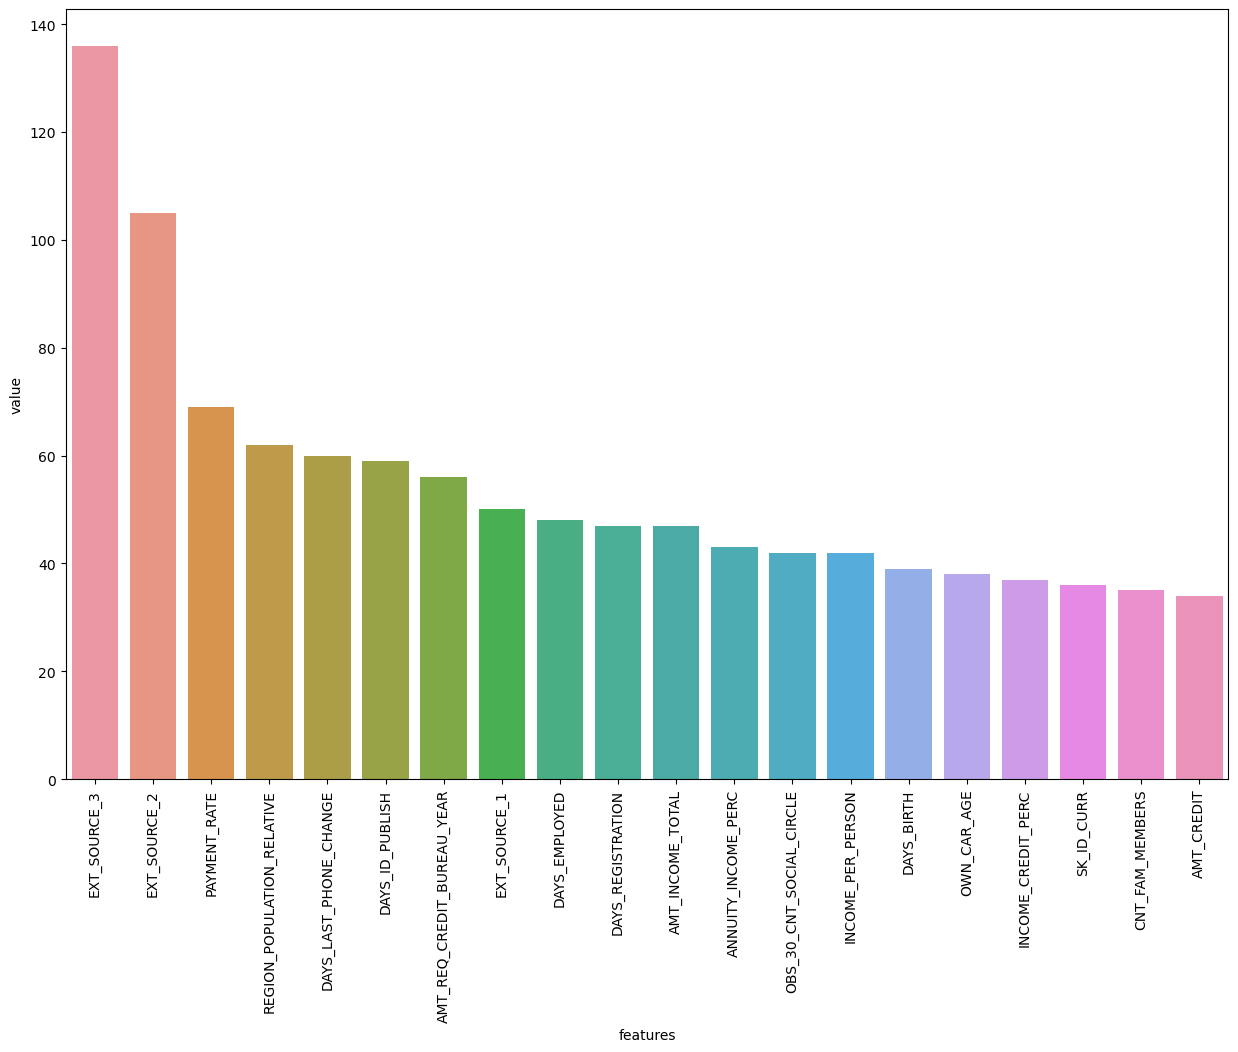

In [132]:
importance = sorted(zip(lgbmetier.feature_importances_, X_test.columns), reverse=True)
plt.figure(figsize=(15,10))
dfImportance = pd.DataFrame(importance, columns=['value', 'features'])
sns.barplot(data=dfImportance[:20], x=dfImportance.features[:20], y=dfImportance.value[:20])
plt.xticks(rotation=90)
plt.savefig('feature_importance.png')
plt.show()

In [ ]:
explainer = shap.Explainer(lgbmetier, X_trainsmote)
shap_values = explainer(X_test)
joblib.dump(explainer, 'feature_importance.joblib')

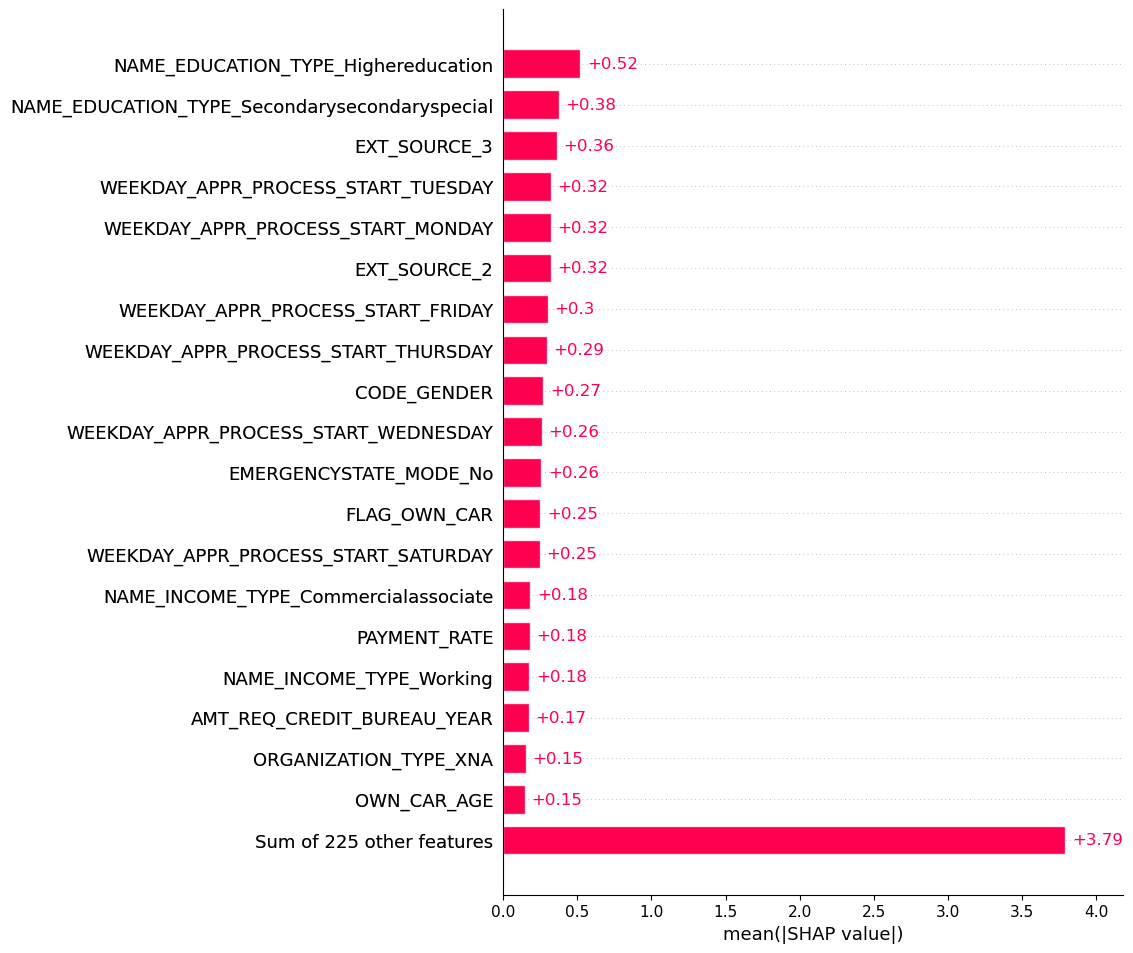

In [140]:
shap.plots.bar(shap_values, max_display=20)

##### Feature importance local

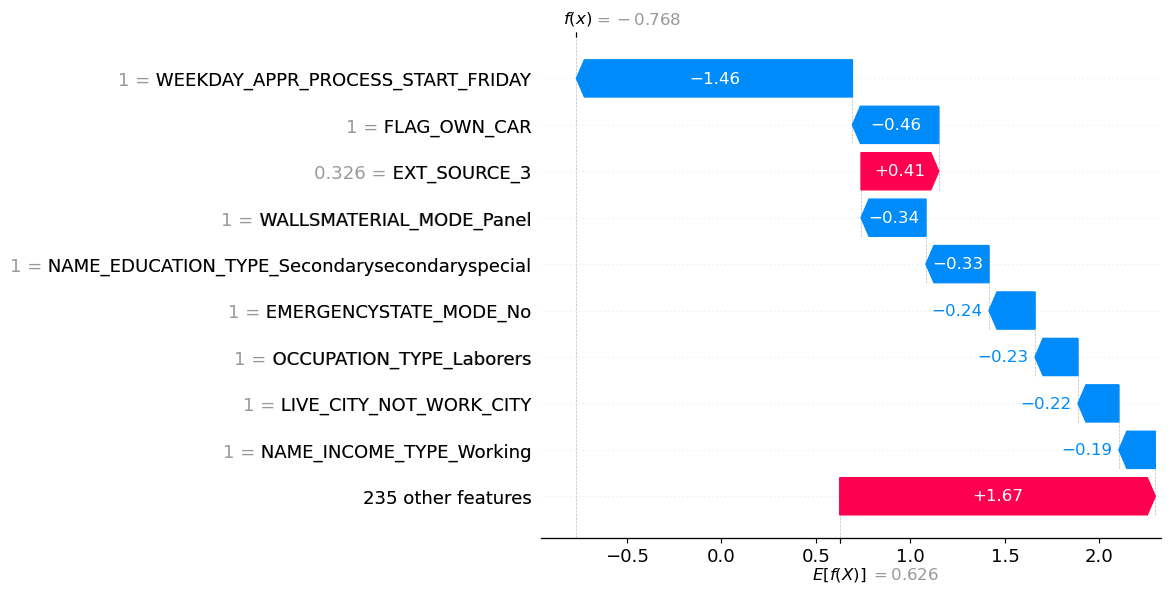

In [136]:
shap.plots.waterfall(shap_values[0])

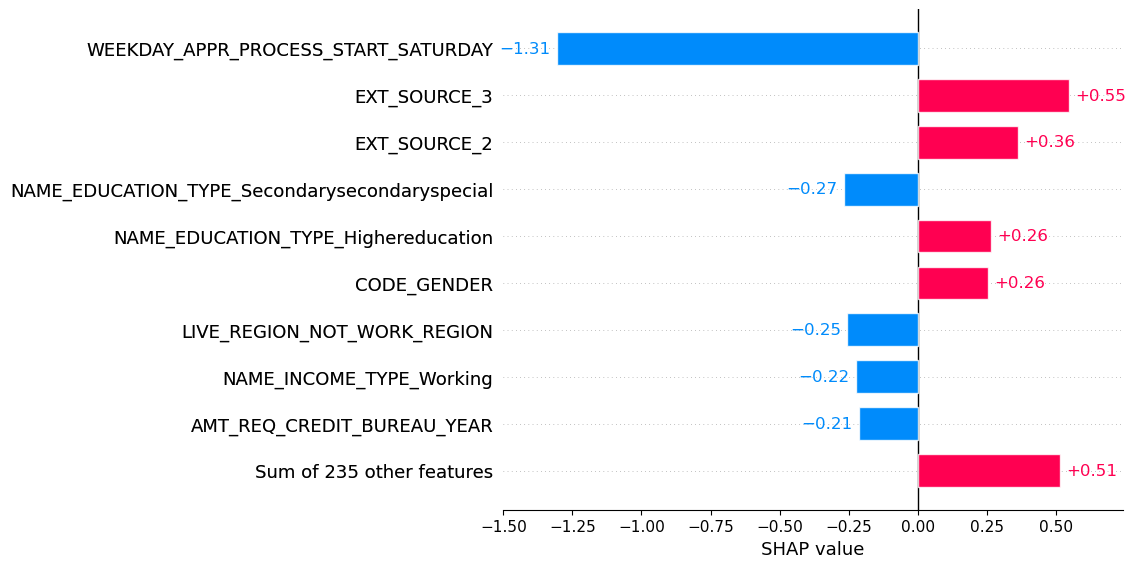

In [73]:
shap.plots.bar(shap_values[4])

In [96]:
test_df = test_df.drop(columns='TARGET')

In [97]:
test_df = test_df[:200]

In [98]:
test_df.to_csv("df_test.csv")

In [84]:
pred1 = pipeline1.predict_proba(test[test.SK_ID_CURR == 100001])

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
